# Data Science Task 2

This is a segmentation task that uses company sales data as the data basis. In this task, customers are to be divided into segments based on their purchasing behavior (customer segmentation). The main task is to identify relevant patterns in the purchasing behavior of customers. Several segmentation solutions are possible. The ones of particular importance to the company are those that are associated with a gain in customer insight, with implications for revenue and profit growth.

In general, a customer segmentation is carried out so that customers can be addressed in a targeted manner or in order to offer suitable products and services to the customer. **Meaningful** differentiation criteria for the company would be the customer price sensitivity, the assortment mix (similarity of the articles purchased by the customer), seasonal buying behavior of the customer, etc.

## Goal of this task

Write a small program that divides customers into customer groups based on their purchasing behavior. Use a suitable, respectively preferred programming language (Python, Matlab, R) or library. You are welcome to use notebooks (e.g., Jupyter Notebook) for the purpose of writing and documenting your code.

For this task several solutions are possible. Therefore, it is important to document the program code. A logging of a progress, function and error report provides extra points in evaluation.
Use company sales data as data basis.

# Scores:

- Final segmentation of customers. The code should be clean, understandable and sufficiently commented. (**50 points**)

- Adequate comments and user instructions. All necessary means (e.g. extra libraries to be installed) to run the program (**10 points**).

- Graphical representation and interpretation of the final solution (your created customer segmentation) (**15 points**)

- Logging of your progress, function and error report (**25 points**)

Total **100 points**

In [1]:
%matplotlib inline
import os
import glob
import numpy as np

from datetime import datetime
import locale
locale.setlocale(locale.LC_ALL, "german")

from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data Cleaning & Exploratory Data Analysis

## Import Modules, Load Data & Data Review

In [24]:
### Import factura data as data frame ###
# The file "DataScienceAufgabe2_FacturaData" is located in folder "/DataScienceAufgabe2/Data/".
# In order to use it in jupyter notebook you have to upload it (See "Upload" Button in http://localhost:8889/tree) )

factura_df = pd.read_csv("DataScienceAufgabe2_FacturaData.csv", encoding="iso-8859-1", decimal=",", sep=";")
# Get column overview
factura_df.dtypes

customerNumber                           int64
purchaseDate                            object
branchNumber                             int64
articleNumber                            int64
quantity                               float64
discountOnRecommendedRetailPrice[%]    float64
purchaseAmount                         float64
dtype: object

In [25]:
factura_df.head()

,customerNumber,purchaseDate,branchNumber,articleNumber,quantity,discountOnRecommendedRetailPrice[%],purchaseAmount
0,557,2021-01-04,19,6013,1.0,0.00,17.24
1,557,2021-01-04,19,6663,2.0,8.37,94.96
2,189,2021-01-04,17,2982,2.0,32.23,59.96
3,490,2021-01-04,19,10658,1.0,25.04,24.05
4,896,2021-01-04,36,14971,3.0,0.00,26.69


In [26]:
factura_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718987 entries, 0 to 718986
Data columns (total 7 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   customerNumber                       718987 non-null  int64  
 1   purchaseDate                         718987 non-null  object 
 2   branchNumber                         718987 non-null  int64  
 3   articleNumber                        718987 non-null  int64  
 4   quantity                             718987 non-null  float64
 5   discountOnRecommendedRetailPrice[%]  718987 non-null  float64
 6   purchaseAmount                       718987 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 38.4+ MB


You can see the data types in the data set. purschaseDate is of data type object. During data visualization this data type can be converted to datetime data type.

## Handling Missing Values

In [28]:
factura_df.isnull().sum()

customerNumber                         0
purchaseDate                           0
branchNumber                           0
articleNumber                          0
quantity                               0
discountOnRecommendedRetailPrice[%]    0
purchaseAmount                         0
dtype: int64

There are no null values in our data set. To optimize the use of machine learning algorithms, null values can be droped if available. 

In [29]:
factura_df.duplicated().value_counts()

False    702623
True      16364
dtype: int64

In [33]:
factura_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerNumber,718987.00,509.37,287.25,1.00,253.00,522.00,746.00,1000.00
branchNumber,718987.00,48.62,29.36,1.00,25.00,42.00,74.00,101.00
articleNumber,718987.00,10418.54,6267.80,1.00,4730.00,10207.00,15982.00,21088.00
quantity,718987.00,15.63,89.42,0.00,1.00,2.00,6.00,13013.00
discountOnRecommendedRetailPrice[%],718987.00,3.53,10.93,0.00,0.00,0.00,0.00,100.00
purchaseAmount,718987.00,123.19,244.96,0.03,21.29,51.96,128.63,24728.52


Here we can roughly analyze the data distribution. There are no negative values for quantity in the data set. It can be concluded that the data set does not indicate order cancellation.  

In [30]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
factura_df.groupby("customerNumber").purchaseAmount.sum()

customerNumber
1      163038.39
2       33761.03
3      179604.73
4       72671.85
5       39094.91
          ...   
996     48100.19
997     36209.25
998    174450.06
999     75466.64
1000    90070.19
Name: purchaseAmount, Length: 1000, dtype: float64

<AxesSubplot:xlabel='customerNumber'>

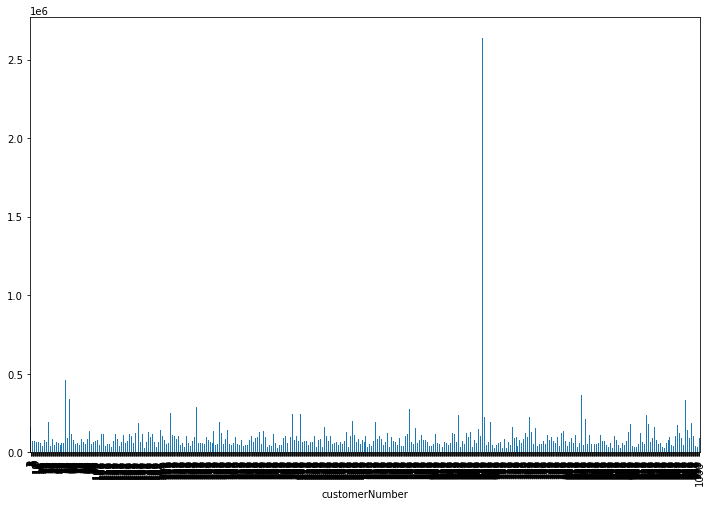

In [32]:
plt.figure(figsize=(12,8))
factura_df.groupby("customerNumber").purchaseAmount.sum().plot(kind="bar")

Where the totals of the purchase amount are grouped by customers. The top ten customers who make the most purchases can be an important piece of information.